In [3]:
pip install torch torchvision opencv-python matplotlib scikit-image

Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


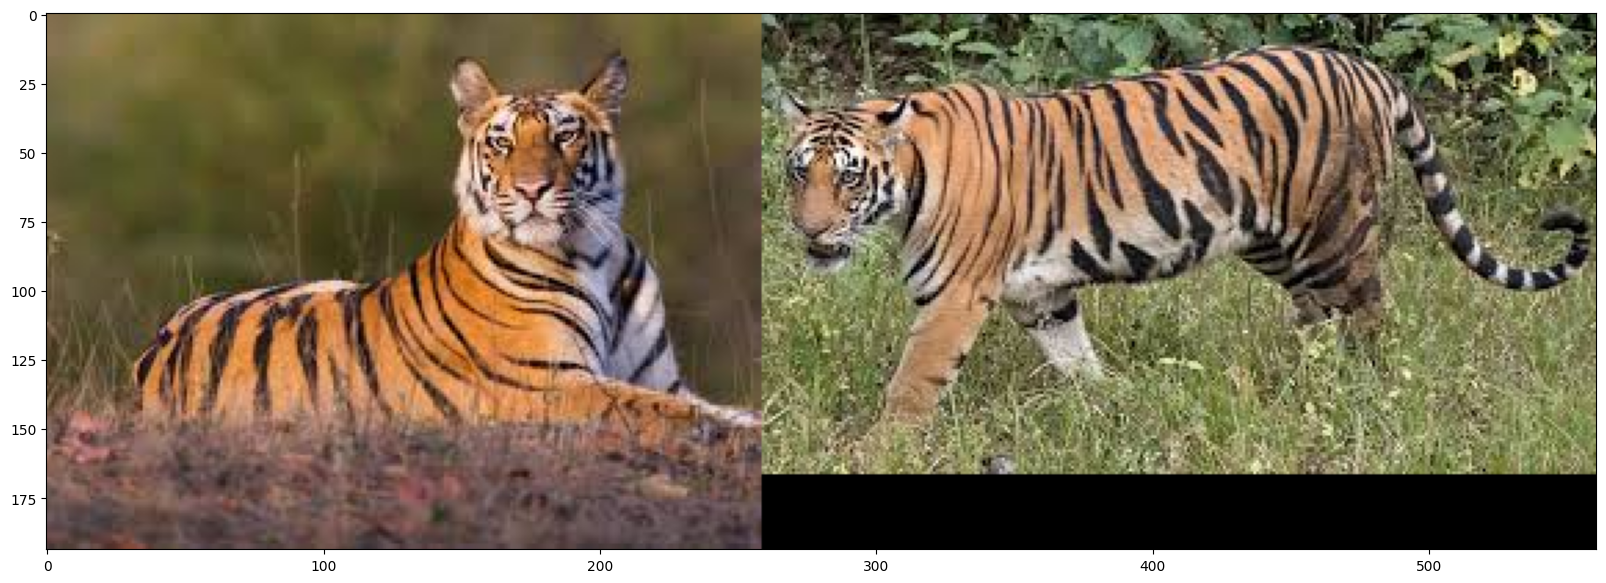

In [1]:
import torch
import torchvision.transforms as T
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the DINOv2 model
model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitg14').eval()

# Define the image preprocessing function
def preprocess_image(image_path):
    transform = T.Compose([
        T.Resize(256, interpolation=T.InterpolationMode.BICUBIC),
        T.CenterCrop(224),
        T.ToTensor(),
        T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ])
    image = Image.open(image_path)
    return transform(image).unsqueeze(0)

# Load and preprocess the images
image1 = preprocess_image('/content/ดาวน์โหลด.jpg')
image2 = preprocess_image('/content/ดาวน์โหลด (1).jpg')

# Extract features
with torch.no_grad():
    features1 = model(image1)
    features2 = model(image2)

# Convert features to numpy arrays
features1_np = features1.squeeze().cpu().numpy()
features2_np = features2.squeeze().cpu().numpy()

# Use SIFT to detect keypoints and compute descriptors
sift = cv2.SIFT_create()
keypoints1, descriptors1 = sift.detectAndCompute(cv2.imread('/content/ดาวน์โหลด.jpg'), None)
keypoints2, descriptors2 = sift.detectAndCompute(cv2.imread('/content/ดาวน์โหลด (1).jpg'), None)

# Use BFMatcher to find the best matches
bf = cv2.BFMatcher()
matches = bf.knnMatch(descriptors1, descriptors2, k=2)

# Apply ratio test to select good matches
good_matches = []
for m, n in matches:
    if m.distance < 0.80 * n.distance:
        good_matches.append(m)

# Load images for visualization
img1 = cv2.imread('/content/ดาวน์โหลด.jpg')
img2 = cv2.imread('/content/ดาวน์โหลด (1).jpg')

# Draw matches
img_matches = cv2.drawMatches(img1, keypoints1, img2, keypoints2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Display the image
plt.figure(figsize=(20, 10))
plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
plt.show()


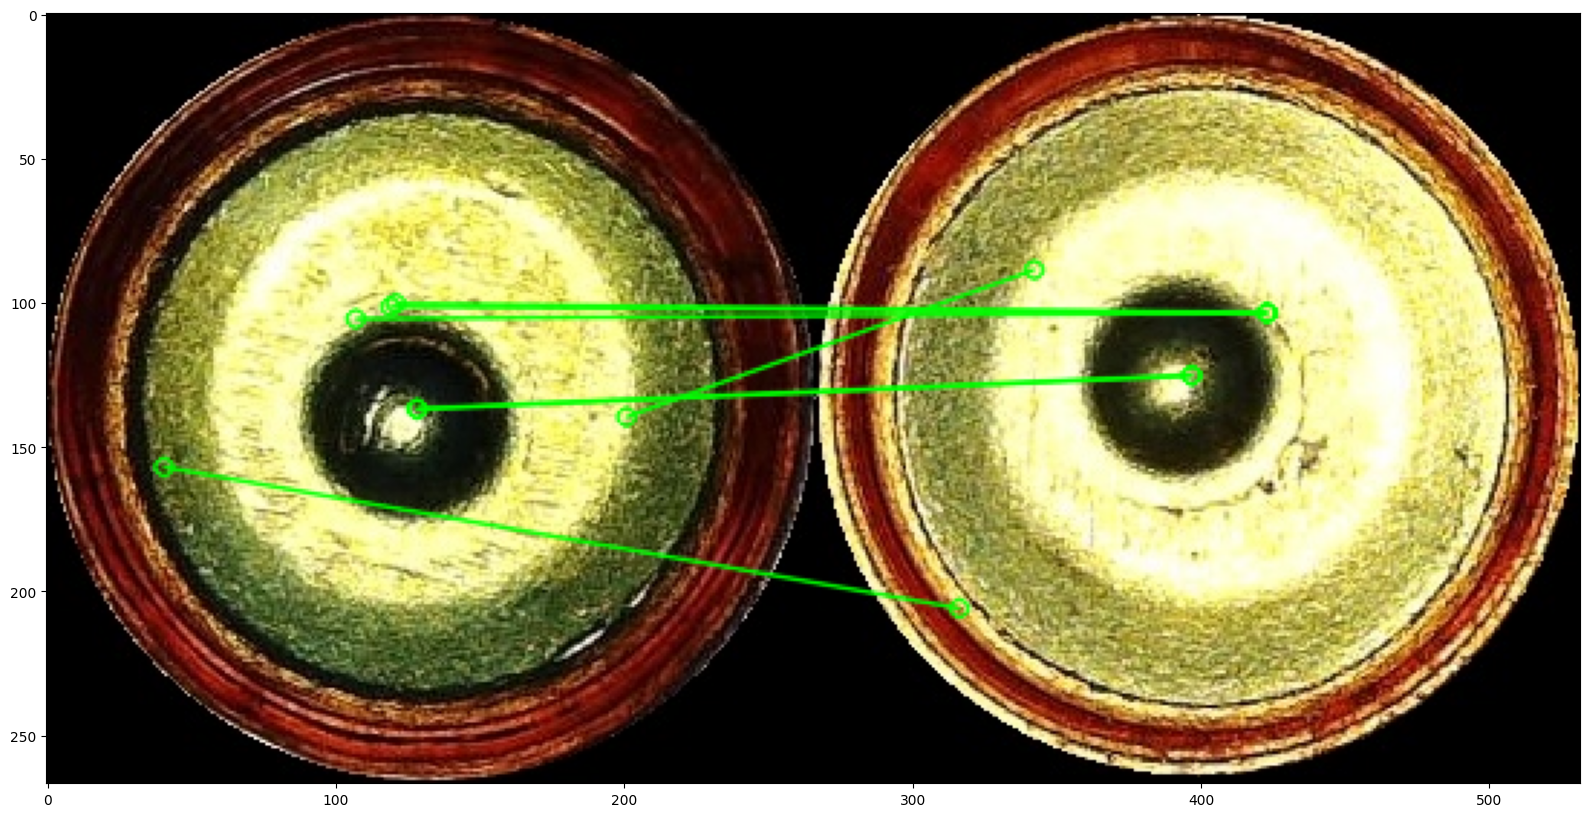

In [13]:
# ฟังก์ชันสำหรับเตรียมการประมวลผลภาพ
def preprocess_image(image_path):
    transform = T.Compose([
        T.Resize(256, interpolation=T.InterpolationMode.BICUBIC),
        T.CenterCrop(224),
        T.ToTensor(),
        T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ])
    image = Image.open(image_path)
    return transform(image).unsqueeze(0)

# โหลดและประมวลผลภาพ
image1 = preprocess_image('/content/01.jpg')
image2 = preprocess_image('/content/02.jpg')

# ดึงฟีเจอร์
with torch.no_grad():
    features1 = model(image1)
    features2 = model(image2)

# แปลงฟีเจอร์เป็น numpy arrays
features1_np = features1.squeeze().cpu().numpy()
features2_np = features2.squeeze().cpu().numpy()

# ใช้ SIFT เพื่อตรวจหาจุดเด่นและคำนวณ descriptors
sift = cv2.SIFT_create()
keypoints1, descriptors1 = sift.detectAndCompute(cv2.imread('/content/01.jpg'), None)
keypoints2, descriptors2 = sift.detectAndCompute(cv2.imread('/content/02.jpg'), None)

# ใช้ BFMatcher เพื่อหาคู่ที่ดีที่สุด
bf = cv2.BFMatcher()
matches = bf.knnMatch(descriptors1, descriptors2, k=2)

# ใช้การทดสอบอัตราส่วนเพื่อกรองคู่ที่ดี
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

# แปลง keypoints และ matches เป็น lists ที่ RANSAC ต้องการ
pts1 = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
pts2 = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

# ใช้ RANSAC เพื่อหาคู่ที่ดีที่สุด
H, mask = cv2.findHomography(pts1, pts2, cv2.RANSAC, 5.0)
matchesMask = mask.ravel().tolist()

# โหลดภาพเพื่อการแสดงผล
img1 = cv2.imread('/content/01.jpg')
img2 = cv2.imread('/content/02.jpg')

# วาดคู่ที่จับคู่กัน
draw_params = dict(matchColor=(0, 255, 0),  # draw matches in green color
                   singlePointColor=None,
                   matchesMask=matchesMask,  # draw only inliers
                   flags=2)

img_matches = cv2.drawMatches(img1, keypoints1, img2, keypoints2, good_matches, None, **draw_params)

# แสดงภาพ
plt.figure(figsize=(20, 10))
plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
plt.show()